# Boosted Algorithms with Approximated Kernel PCA Features
This notebook evaluates all major gradient boosting frameworks using high-dimensional features compressed via **Nystroem Approximated Kernel PCA**.

### Workflow:
1.  **Bucketing**: Features are grouped into Volume, Volatility, Momentum, and Trend.
2.  **Compression**: Each bucket is reduced to its primary non-linear components using Nystroem + PCA.
3.  **Modeling**: A battery of boosted models are trained and backtested:
    - XGBoost
    - LightGBM
    - CatBoost
    - AdaBoost
    - Gradient Boosting (sklearn)
    - Hist Gradient Boosting (sklearn)

In [ ]:
!pip install xgboost lightgbm catboost --quiet


In [13]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from bokeh.io import output_notebook, show

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

output_notebook()

if os.getcwd().endswith('notebooks/boosted algorithms'):
    os.chdir('../..')
ROOT = os.getcwd()
if ROOT not in sys.path: sys.path.insert(0, ROOT)

from src.backtester.data import align_close_prices, load_cleaned_assets
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.bokeh_plots import build_interactive_portfolio_layout

FEATURES_PATH = 'dataset/features/all_features.parquet'
TARGET_FWD = 'y_ret_1d_fwd'
CUTOFF = '2023-01-01'
SEED = 42

all_res = {}
equities = {}

Loading BokehJS ...

## 1) Data Prep & Bucket Kernel PCA

In [14]:
df = pd.read_parquet(FEATURES_PATH)
if 'Date' in df.columns: df = df.set_index('Date')
df[TARGET_FWD] = df.groupby('Asset_ID', sort=False)['ret_1d'].shift(-1)
df = df.dropna(subset=[TARGET_FWD])

volume_cols = [c for c in df.columns if any(p in c for p in ['volume', 'obv', 'ad_line'])]
volatility_cols = [c for c in df.columns if any(p in c for p in ['roll_std', 'roll_var', 'roll_min', 'roll_max', 'atr', 'realized_vol', 'bb_bandwidth', 'bb_percent_b'])]
momentum_cols = [c for c in df.columns if any(p in c for p in ['ret_lag', 'ret_5d', 'ret_21d', 'cumret', 'rsi', 'macd', 'rmacd', 'roc', 'stoch', 'cci', 'filt_resid'])]
trend_cols = [c for c in df.columns if any(p in c for p in ['sma', 'ema', 'diff_log', 'ha_ha', 'bb_mid', 'bb_upper', 'bb_lower', 'adx', 'aroon', 'ichimoku', 'fib', 'bos', 'choch', 'mss', 'filt_close', 'filt_logret'])]

buckets = {
    'Volume': volume_cols,
    'Volatility': volatility_cols,
    'Trend': trend_cols,
    'Momentum': momentum_cols
}

# Remove overlap and ensure valid columns
seen = set()
for b in buckets:
    buckets[b] = [c for c in buckets[b] if c in df.columns and c not in seen]
    seen.update(buckets[b])

df_train = df[df.index < CUTOFF].copy()
df_test = df[df.index >= CUTOFF].copy()

tr_feats, te_feats = [], []
for b_name, cols in buckets.items():
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('kpca_approx', Nystroem(kernel='poly', degree=2, n_components=100, random_state=SEED)),
        ('pca_distill', PCA(n_components=3))
    ])
    X_tr = df_train[cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    X_te = df_test[cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    tr_feats.append(pipe.fit_transform(X_tr))
    te_feats.append(pipe.transform(X_te))

X_tr_stacked = np.hstack(tr_feats)
X_te_stacked = np.hstack(te_feats)
y_tr = df_train[TARGET_FWD]

## 2) Model Battery

In [15]:
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, n_jobs=-1, random_state=SEED),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, n_jobs=-1, random_state=SEED, verbose=-1),
    'CatBoost': CatBoostRegressor(n_estimators=100, learning_rate=0.05, depth=6, verbose=0, random_state=SEED),
    'AdaBoost': AdaBoostRegressor(n_estimators=50, random_state=SEED),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=SEED),
    'HistGBR': HistGradientBoostingRegressor(max_iter=100, max_depth=6, random_state=SEED)
}

test_syms = df_test['Asset_ID'].unique()
close_prices = align_close_prices(load_cleaned_assets(symbols=test_syms))
close_prices = close_prices[close_prices.index >= CUTOFF]

for name, model in models.items():
    print(f'\n--- Testing {name} ---')
    model.fit(X_tr_stacked, y_tr)
    preds = model.predict(X_te_stacked)
    df_out = df_test.copy(); df_out['y_pred'] = preds
    w = df_out.pivot(columns='Asset_ID', values='y_pred').reindex(close_prices.index).fillna(0)
    w_rank = w.rank(axis=1, ascending=False)
    w_final = ((w_rank <= 5) & (w > 0)).astype(float)
    w_final = w_final.div(w_final.sum(axis=1).replace(0, 1), axis=0)
    res = run_backtest(close_prices, w_final, BacktestConfig())
    rep = compute_backtest_report(result=res, close_prices=close_prices)
    print(rep)
    all_res[name], equities[name] = rep, res.equity
    mkt = pd.DataFrame(index=close_prices.index); mkt['Close'] = close_prices.iloc[:, 0]
    for c in ['Open', 'High', 'Low']: mkt[c] = mkt['Close']
    mkt['Volume'] = 0
    show(build_interactive_portfolio_layout(
        market_ohlcv=mkt, 
        equity=res.equity, 
        returns=res.returns, 
        weights=res.weights, 
        turnover=res.turnover, 
        costs=res.costs, 
        title=f"{name} (Approximated Kernel PCA)"
    ))



--- Testing XGBoost ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       2467838.415215
Equity Peak                        2601294.589915
Total Return [%]                       146.783842
CAGR [%]                                34.816341
Volatility (ann) [%]                    25.544685
Sharpe                                   1.295824
Sortino                                  2.209702
Max Drawdown [%]                       -20.613945
Calmar                                    1.68897
Best Day [%]                            12.276977
Worst Day [%]                           -7.814485
Avg Gross Exposure                       0.999212
Avg Net Exposure                         0.999212
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover           


--- Testing LightGBM ---


/home/anivarth/college/quant-task/.venv_uv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       2704431.272386
Equity Peak                        2870954.648079
Total Return [%]                       170.443127
CAGR [%]                                38.960465
Volatility (ann) [%]                    26.180521
Sharpe                                     1.3856
Sortino                                  2.478817
Max Drawdown [%]                       -21.823081
Calmar                                   1.785287
Best Day [%]                            14.970449
Worst Day [%]                           -8.727961
Avg Gross Exposure                       0.999199
Avg Net Exposure                         0.999199
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover                  1304452669.591913



--- Testing CatBoost ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       1840984.648375
Equity Peak                        1932227.828891
Total Return [%]                        84.098465
CAGR [%]                                22.364203
Volatility (ann) [%]                    27.322314
Sharpe                                   0.873362
Sortino                                  1.498765
Max Drawdown [%]                       -28.638642
Calmar                                    0.78091
Best Day [%]                            16.185164
Worst Day [%]                           -8.040707
Avg Gross Exposure                       0.999117
Avg Net Exposure                         0.999117
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover          


--- Testing AdaBoost ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       1021599.971028
Equity Peak                        1052660.525039
Total Return [%]                         2.159997
CAGR [%]                                 0.709228
Volatility (ann) [%]                    17.384039
Sharpe                                   0.126661
Sortino                                   0.22037
Max Drawdown [%]                       -32.243866
Calmar                                   0.021996
Best Day [%]                            12.033794
Worst Day [%]                           -6.286064
Avg Gross Exposure                       0.999391
Avg Net Exposure                         0.999391
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover          


--- Testing GradientBoosting ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       2378055.797518
Equity Peak                        2468228.670088
Total Return [%]                        137.80558
CAGR [%]                                33.174136
Volatility (ann) [%]                    30.933644
Sharpe                                   1.078514
Sortino                                  1.861209
Max Drawdown [%]                       -23.556235
Calmar                                   1.408295
Best Day [%]                             18.56954
Worst Day [%]                            -9.03981
Avg Gross Exposure                       0.970319
Avg Net Exposure                         0.970319
Exposure Time [%]                       96.985583
Rebalance Days                                752
Total Turnover  


--- Testing HistGBR ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       1432430.448663
Equity Peak                        1492866.200557
Total Return [%]                        43.243045
CAGR [%]                                12.619831
Volatility (ann) [%]                    26.470584
Sharpe                                   0.579856
Sortino                                  0.985874
Max Drawdown [%]                       -24.872025
Calmar                                   0.507391
Best Day [%]                            14.970449
Worst Day [%]                           -7.776889
Avg Gross Exposure                       0.999207
Avg Net Exposure                         0.999207
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover           

## 3) Summary Comparison

,CAGR [%],Sharpe,Max Drawdown [%]
XGBoost,34.816341,1.295824,-20.613945
LightGBM,38.960465,1.3856,-21.823081
CatBoost,22.364203,0.873362,-28.638642
AdaBoost,0.709228,0.126661,-32.243866
GradientBoosting,33.174136,1.078514,-23.556235
HistGBR,12.619831,0.579856,-24.872025


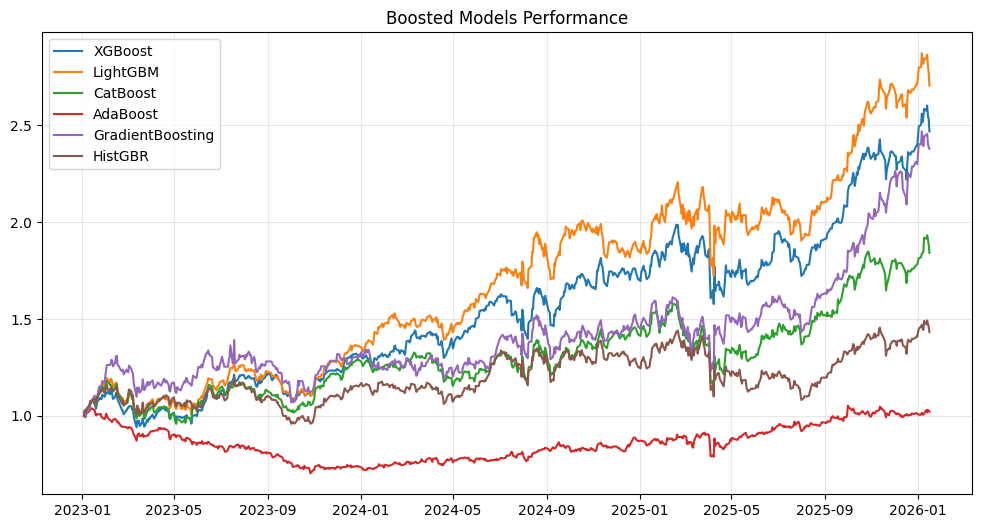

In [16]:
summary = pd.DataFrame(all_res).T[['CAGR [%]', 'Sharpe', 'Max Drawdown [%]']]
display(summary)
plt.figure(figsize=(12, 6))
for name, eq in equities.items(): plt.plot(eq/eq.iloc[0], label=name)
plt.title("Boosted Models Performance"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()